In [232]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector

[Tech industry layoffs in 2022](https://www.kaggle.com/datasets/swaptr/layoffs-2022)



In [135]:
data = pd.read_csv('layoffs.csv')
data

,company,location,industry,total_laid_off,percentage,date,funds_raised,stage,country
0,Veev,SF Bay Area,Real Estate,100.0,0.30,2022-11-11,597.0,Series D,United States
1,GoTo Group,Jakarta,Transportation,1000.0,0.10,2022-11-10,1300.0,Unknown,Indonesia
2,Juul,SF Bay Area,Consumer,400.0,0.30,2022-11-10,1500.0,Unknown,United States
3,InfluxData,SF Bay Area,NaN,65.0,0.27,2022-11-10,119.0,Series D,United States
4,Coinbase,SF Bay Area,Crypto,60.0,NaN,2022-11-10,549.0,IPO,United States
...,...,...,...,...,...,...,...,...,...
1569,Service,Los Angeles,Travel,NaN,1.00,2020-03-16,5.1,Seed,United States
1570,HopSkipDrive,Los Angeles,Transportation,8.0,0.10,2020-03-13,45.0,Unknown,United States
1571,Panda Squad,SF Bay Area,Consumer,6.0,0.75,2020-03-13,1.0,Seed,United States
1572,Tamara Mellon,Los Angeles,Retail,20.0,0.40,2020-03-12,90.0,Series C,United States


I find it more interesting to predict on 'percentage' rather than total_laid_off. That way, we can assess the impact of layoffs agnostic to the size of the company.

Let's also focus just on jobs in the US.

One-hot encoding:
- Company
- Location
- Industry
- Country
- Stage

Ordinal encoding: 
- Date (let's parse it by month/year instead of day)

In [136]:
# We're focusing on percentage, so drop total_laid_off
del data['total_laid_off']

# Refine dataset to only include jobs within the US
data = data.query('country == "United States"')
del data['country']

# Company agnostic too
del data['company']

# Snip the last 3 characters to isolate on month/year only.
data['date'] = data['date'].agg(lambda x: x[:-3])

# For the sake of speed, dropna
data = data.dropna()

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [137]:
# Data distribution
px.density_heatmap(data, x='date', y='percentage')

Note that we use handle_unknown='ignore' for the One-Hot Encoder. Therefore, the dataset ought to be k-fold cross-validated in order to ensure coverage over the entire dataset. This also will inflate MSE slightly, as unknowns will be handled 'incorrectly' as 0's.

Between the one-hot encoding and polynomial features, there can end up being more than 1e6 features. As such, I choose to use LASSO, which will tend to minimize insignificant features to 0 rather than simply weighting them poorly. This allows us to more-clearly pick out favored features.

In [200]:
encoder = make_column_transformer(

        (OneHotEncoder(drop='if_binary', handle_unknown='ignore'), ['location', 'industry', 'stage']),

        # Calibrate ordinal encoder for 1-n by sorting 2020-03 to latest
        (OrdinalEncoder(categories = [ list( data['date'].value_counts().index.sort_values() ) ] ), ['date']) ,

        remainder='passthrough' )

# Instantiate model
model = Pipeline((
    ('enc', encoder ),

    ('pft', PolynomialFeatures(degree=3)),
    ('lr', Lasso() ),
))

In [265]:
# Define a parameterspace
parameters = {'lr__alpha':np.logspace(-5,2,15)}

In [266]:
# Use k-fold cross validation over k=3
gs = GridSearchCV( estimator = model, param_grid = parameters, scoring = 'neg_mean_squared_error', cv = 3, verbose=2)

In [267]:
y = data['percentage']
X = data.drop(['percentage'], axis=1)

gs.fit(X, y)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1973254716563572, tolerance: 0.003214229941233032

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ....................................lr__alpha=1e-05; total time=   3.5s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.41444267923490496, tolerance: 0.0025725755191873595

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ....................................lr__alpha=1e-05; total time=   2.6s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4057836089616496, tolerance: 0.0031083435041760715

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



[CV] END ....................................lr__alpha=1e-05; total time=   2.7s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3171922680680452, tolerance: 0.003214229941233032

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ...................lr__alpha=3.1622776601683795e-05; total time=   2.7s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.532113940339102, tolerance: 0.0025725755191873595

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ...................lr__alpha=3.1622776601683795e-05; total time=   2.8s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5092138391703483, tolerance: 0.0031083435041760715

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



[CV] END ...................lr__alpha=3.1622776601683795e-05; total time=   2.3s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6146894064494407, tolerance: 0.003214229941233032

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ...................................lr__alpha=0.0001; total time=   2.1s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7949154238882417, tolerance: 0.0025725755191873595

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ...................................lr__alpha=0.0001; total time=   2.1s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6138677442960792, tolerance: 0.0031083435041760715

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



[CV] END ...................................lr__alpha=0.0001; total time=   2.9s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.303081773463624, tolerance: 0.003214229941233032

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ...................lr__alpha=0.00031622776601683794; total time=   2.1s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3972638731997462, tolerance: 0.0025725755191873595

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ...................lr__alpha=0.00031622776601683794; total time=   1.9s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8274417358577428, tolerance: 0.0031083435041760715

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



[CV] END ...................lr__alpha=0.00031622776601683794; total time=   2.1s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5431206924489285, tolerance: 0.003214229941233032

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ....................................lr__alpha=0.001; total time=   2.0s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.425874198258464, tolerance: 0.0025725755191873595

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ....................................lr__alpha=0.001; total time=   1.9s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3346795677979413, tolerance: 0.0031083435041760715

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



[CV] END ....................................lr__alpha=0.001; total time=   2.1s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.046244517548532, tolerance: 0.003214229941233032

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ....................lr__alpha=0.0031622776601683794; total time=   2.1s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.568528339696708, tolerance: 0.0025725755191873595

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ....................lr__alpha=0.0031622776601683794; total time=   1.9s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4437925620772942, tolerance: 0.0031083435041760715

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



[CV] END ....................lr__alpha=0.0031622776601683794; total time=   2.1s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.90977789075845, tolerance: 0.003214229941233032

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END .....................................lr__alpha=0.01; total time=   2.0s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.086052064980555, tolerance: 0.0025725755191873595

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END .....................................lr__alpha=0.01; total time=   1.9s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.16645677265285, tolerance: 0.0031083435041760715

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



[CV] END .....................................lr__alpha=0.01; total time=   2.0s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.648750328164191, tolerance: 0.003214229941233032

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ......................lr__alpha=0.03162277660168379; total time=   2.0s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.520549729473833, tolerance: 0.0025725755191873595

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ......................lr__alpha=0.03162277660168379; total time=   1.8s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.107896400381462, tolerance: 0.0031083435041760715

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



[CV] END ......................lr__alpha=0.03162277660168379; total time=   2.0s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.520115715331954, tolerance: 0.003214229941233032

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ......................................lr__alpha=0.1; total time=   1.9s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.012586835655908, tolerance: 0.0025725755191873595

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ......................................lr__alpha=0.1; total time=   1.7s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.7650590854111226, tolerance: 0.0031083435041760715

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



[CV] END ......................................lr__alpha=0.1; total time=   3.1s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.302854748903979, tolerance: 0.003214229941233032

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ......................lr__alpha=0.31622776601683794; total time=   2.1s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.253586766231246, tolerance: 0.0025725755191873595

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ......................lr__alpha=0.31622776601683794; total time=   1.8s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.411477658252204, tolerance: 0.0031083435041760715

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



[CV] END ......................lr__alpha=0.31622776601683794; total time=   2.0s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.563549787423016, tolerance: 0.003214229941233032

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ......................................lr__alpha=1.0; total time=   2.5s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.27205618522251, tolerance: 0.0025725755191873595

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ......................................lr__alpha=1.0; total time=   1.7s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.07028934771877, tolerance: 0.0031083435041760715

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



[CV] END ......................................lr__alpha=1.0; total time=   2.4s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.301513510729901, tolerance: 0.003214229941233032

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END .......................lr__alpha=3.1622776601683795; total time=   1.9s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.0481090172487, tolerance: 0.0025725755191873595

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END .......................lr__alpha=3.1622776601683795; total time=   1.8s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.479197458188628, tolerance: 0.0031083435041760715

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



[CV] END .......................lr__alpha=3.1622776601683795; total time=   1.9s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.835135342005978, tolerance: 0.003214229941233032

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END .....................................lr__alpha=10.0; total time=   2.6s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.488090327178652, tolerance: 0.0025725755191873595

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END .....................................lr__alpha=10.0; total time=   1.8s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.323737333152343, tolerance: 0.0031083435041760715

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



[CV] END .....................................lr__alpha=10.0; total time=   2.0s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.294978570192693, tolerance: 0.003214229941233032

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END .......................lr__alpha=31.622776601683793; total time=   2.1s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.777284091188056, tolerance: 0.0025725755191873595

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END .......................lr__alpha=31.622776601683793; total time=   1.7s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.781784415255276, tolerance: 0.0031083435041760715

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



[CV] END .......................lr__alpha=31.622776601683793; total time=   3.4s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.66221481398325, tolerance: 0.003214229941233032

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ....................................lr__alpha=100.0; total time=   1.7s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.965587051415914, tolerance: 0.0025725755191873595

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros



[CV] END ....................................lr__alpha=100.0; total time=   1.6s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.220425416902152, tolerance: 0.0031083435041760715

/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:174: UserWarning:

Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros



[CV] END ....................................lr__alpha=100.0; total time=   2.8s


/Users/xboluna/opt/miniconda3/envs/threeML/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.247067171546348, tolerance: 0.004463706426468374



GridSearchCV(cv=3,
             estimator=Pipeline(steps=(('enc',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore'),
                                                                         ['location',
                                                                          'industry',
                                                                          'stage']),
                                                                        ('ordinalencoder',
                                                                         OrdinalEncoder(categories=[['2020-03',
                                                                                   

Text(0.5, 0, '$\\alpha$')

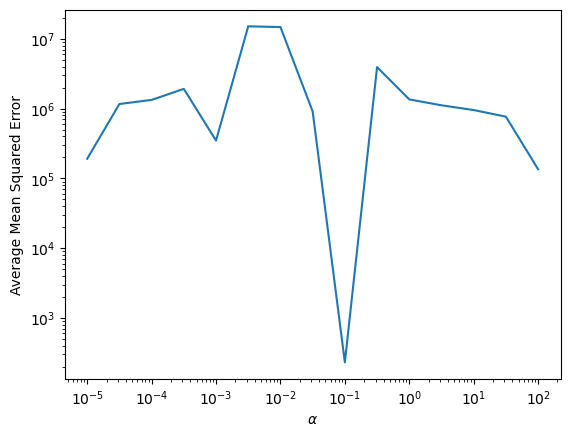

In [273]:
fig, ax = plt.subplots()
ax.loglog(parameters['lr__alpha'], np.abs(gs.cv_results_['mean_test_score']))

ax.set_ylabel('Average Mean Squared Error')
ax.set_xlabel(r'$\alpha$')

In [271]:
best_model = gs.best_estimator_

coefs = best_model[2].coef_
len(coefs[coefs>0])

110